In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import vit_b_16, vit_b_32
from torchvision.models.vision_transformer import VisionTransformer
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as tf
import numpy as np
from torch.cuda.amp import GradScaler, autocast
from PIL import Image, ImageDraw, ImageFont

In [2]:
# Convert a pytorch tensor into a PIL image
t2img = transforms.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = transforms.ToTensor()

# Set the working (writable) directory.
# working_dir = "./"

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a standard size
    transforms.ToTensor()  # Convert image to tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize for pretrained models
    #                     std=[0.229, 0.224, 0.225])
])

In [4]:
# Transforms for the images
image_transforms = Compose([
    Resize((224, 224)),
    transforms.ToTensor()
])

# Transforms for the trimaps
trimap_transforms = Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

In [5]:
class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={self.device})"

In [6]:
def getDevice():
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  return device

In [7]:
class OxfordIIITPetsAugmented(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)

        # Common transforms are performed on both the input and the labels
        # by creating a 4 channel image and running the transform on both.
        # Then the segmentation mask (4th channel) is separated out.
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        # end if

        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)

In [9]:
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

def args_to_dict(**kwargs):
    return kwargs

transform_dict = args_to_dict(
    pre_transform=transforms.ToTensor(),
    pre_target_transform=transforms.ToTensor(),
    common_transform=transforms.Compose([
        ToDevice(getDevice()),
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
        # Random Horizontal Flip as data augmentation.
        transforms.RandomHorizontalFlip(p=0.5),
    ]),
    post_transform=transforms.Compose([
        # Color Jitter as data augmentation.
        transforms.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=transforms.Compose([
        transforms.Lambda(tensor_trimap),
    ]),
)

# Create the train and test instances of the data loader for the
# Oxford IIIT Pets dataset with random augmentations applied.
# The images are resized to 128x128 squares, so the aspect ratio
# will be chaged. We use the nearest neighbour resizing algorithm
# to avoid disturbing the pixel values in the provided segmentation
# mask.
train_dataset = OxfordIIITPetsAugmented(
    root='./OxfordPets',
    split="trainval",
    target_types="segmentation",
    download=False,
    **transform_dict,
)
test_dataset = OxfordIIITPetsAugmented(
    root='./OxfordPets',
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

trainloader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
)
testloader = DataLoader(
    test_dataset,
    batch_size=21,
    shuffle=True,
)

(train_pets_inputs, train_pets_targets) = next(iter(trainloader))
(test_pets_inputs, test_pets_targets) = next(iter(testloader))
train_pets_inputs.shape, train_pets_targets.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 1, 224, 224]))

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# dataset = DataLoader(pet_dataset, batch_size=10, shuffle=True)
# # dataset = datasets.ImageFolder(root='./PetImages', transform=transform)

# trainsize = int(0.8 * len(dataset))
# testsize = len(dataset) - trainsize

# traindataset, testdataset = random_split(dataset, [trainsize, testsize])

# trainloader = DataLoader(traindataset, batch_size=20, shuffle=True)
# testloader = DataLoader(testdataset, batch_size=20, shuffle=False)
# dataset = torchvision.datasets.OxfordIIITPet(root='./data', download=True, transform=transform)

# trainsize = int(0.8 * len(dataset))
# testsize = len(dataset) - trainsize
# traindataset, testdataset = random_split(dataset, [trainsize, testsize])

# # Create DataLoader for train and test sets
# trainloader = DataLoader(traindataset, batch_size=20, shuffle=True)
# testloader = DataLoader(testdataset, batch_size=20, shuffle=False)

# pets_path_train = os.path.join(working_dir, 'OxfordPets', 'train')
# pets_path_test = os.path.join(working_dir, 'OxfordPets', 'test')
# trainloader = torchvision.datasets.OxfordIIITPet(root='./OxfordPets', split="trainval", target_types="segmentation",download=True,transforms=transform,target_transform=trimap_transforms)
# testloader = torchvision.datasets.OxfordIIITPet(root='./OxfordPets', split="test", target_types="segmentation", download=True,transforms=transform,target_transform=trimap_transforms)
train_dataset = torchvision.datasets.OxfordIIITPet(
    root='./OxfordPets',
    split="trainval",
    target_types="segmentation",
    transform=image_transforms,
    target_transform=trimap_transforms,
    download=True
)

test_dataset = torchvision.datasets.OxfordIIITPet(
    root='./OxfordPets',
    split="test",
    target_types="segmentation",
    transform=image_transforms,
    target_transform=trimap_transforms,
    download=True
)

trainloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=20, shuffle=False)

100%|██████████| 791918971/791918971 [00:57<00:00, 13672611.13it/s]


Extracting OxfordPets/oxford-iiit-pet/images.tar.gz to OxfordPets/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 7508671.84it/s] 


Extracting OxfordPets/oxford-iiit-pet/annotations.tar.gz to OxfordPets/oxford-iiit-pet


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# 新段落

In [ ]:
(train_pets_input, train_pets_target) = train_dataset[90]

In [ ]:
from enum import IntEnum
class TrimapClasses(IntEnum):
    PET = 0
    BACKGROUND = 1
    BORDER = 2

In [ ]:
# Convert a float trimap ({1, 2, 3} / 255.0) into a float tensor with
# pixel values in the range 0.0 to 1.0 so that the border pixels
# can be properly displayed.
def trimap2f(trimap):
    return (img2t(trimap) * 255.0 - 1) / 2

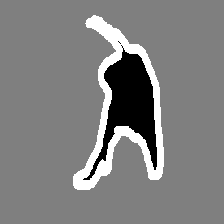

In [ ]:
t2img(trimap2f(train_pets_target))

In [ ]:
device

device(type='cuda')

In [11]:
class ViT_16(nn.Module):
    def __init__(self, image_size=224, patch_size=16, num_classes=3, hidden_dim=768):
        super(ViT_16, self).__init__()

        self.vit = vit_b_16(weights=None)
        self.vit.heads = nn.Identity()

        self.num_classes = num_classes
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2

        self.projection = nn.Linear(hidden_dim, num_classes * image_size * image_size)

        self.fold = nn.Fold(output_size=(image_size, image_size), kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        batch_size = x.size(0)

        # extract features from vit [batch_size, hidden_dim]
        features = self.vit(x)
        #print(features.shape)

        projected_features = self.projection(features)
        #print(projected_features.shape)
        projected_features = projected_features.view(batch_size, self.num_classes, self.image_size * self.image_size)
        #print(projected_features.shape)

        # adjust dimension
        projected_features = projected_features.transpose(1, 2).contiguous()
        projected_features = projected_features.view(batch_size, -1, self.num_patches)

        # reconstruct segmentation map
        segmentation_maps = self.fold(projected_features)
        #print(segmentation_maps.shape)

        # segmentation_maps [batch_size, num_classes * patch_height * patch_width, L]
        # 其中 L = num_patches
        segmentation_maps = segmentation_maps.view(batch_size, self.num_classes, self.image_size, self.image_size)
        #print(segmentation_maps.shape) # [batch_size, num_classes, 224, 244]

        return segmentation_maps

In [12]:
class ViT_32(nn.Module):
    def __init__(self, image_size=224, patch_size=32, num_classes=3, hidden_dim=768):
        super(ViT_32, self).__init__()

        self.vit = vit_b_32(weights=None)
        self.vit.heads = nn.Identity()

        self.num_classes = num_classes
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2

        self.projection = nn.Linear(hidden_dim, num_classes * image_size * image_size)

        self.fold = nn.Fold(output_size=(image_size, image_size), kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        batch_size = x.size(0)

        # extract features from vit [batch_size, hidden_dim]
        features = self.vit(x)
        #print(features.shape)

        projected_features = self.projection(features)
        #print(projected_features.shape)
        projected_features = projected_features.view(batch_size, self.num_classes, self.image_size * self.image_size)
        #print(projected_features.shape)

        # adjust dimension
        projected_features = projected_features.transpose(1, 2).contiguous()
        projected_features = projected_features.view(batch_size, -1, self.num_patches)

        # reconstruct segmentation map
        segmentation_maps = self.fold(projected_features)
        #print(segmentation_maps.shape)

        # segmentation_maps [batch_size, num_classes * patch_height * patch_width, L]
        # 其中 L = num_patches
        segmentation_maps = segmentation_maps.view(batch_size, self.num_classes, self.image_size, self.image_size)
        #print(segmentation_maps.shape) # [batch_size, num_classes, 224, 244]

        return segmentation_maps

In [13]:
# Initialize the Vit_b_16
# vit = vit_b_16(weights = None, num_classes = 2).to(device)
vit = ViT_16(num_classes=3,image_size=224).to(device)

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vit.parameters(), lr=0.001, momentum=0.9)

# Initialize the Vit_b_32
vitb_32 = ViT_32(num_classes=3,image_size=224).to(device)

# optimizer
optimizer1 = optim.SGD(vitb_32.parameters(), lr=0.001, momentum=0.9)

In [14]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    total_batches = 0
    print_interval = 50

    for batch_idx, (inputs, trimaps) in enumerate(dataloader):
        inputs = inputs.to(device)
        trimaps = trimaps.to(device).squeeze(1).long()

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, trimaps)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_batches += 1

        if (batch_idx + 1) % print_interval == 0:
            print(f'Batch {batch_idx + 1}, '
                  f'Average Training Loss: {running_loss / total_batches:.4f}')

    average_loss = running_loss / total_batches
    return average_loss


In [15]:
def test(model, loader, device):
    model.eval()
    ious = []
    dice_scores = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = torch.argmax(outputs, dim=1)  # Convert softmax output to class predictions

            for i in range(inputs.size(0)):  # Iterate through batch
                pred = outputs[i]
                pred = pred.squeeze()
                true = labels[i]
                true = true.squeeze()

                # Assuming true and pred are already 2D [224, 224], create a mask for valid pixels
                valid_mask = (true != 255)
                # print(valid_mask.shape)
                valid_mask = valid_mask.squeeze(0)
                # print(valid_mask.shape)

                # Apply the mask to both pred and true to filter out invalid pixels
                pred_valid = pred[valid_mask]
                true_valid = true[valid_mask]

                # Calculate IoU
                intersection = (pred_valid == true_valid)
                union = (pred_valid == true_valid) | (true_valid != 255)
                iou = intersection.sum().item() / union.sum().item()
                ious.append(iou)

                # Calculate Dice score
                dice = 2 * intersection.sum().item() / (pred_valid.sum().item() + true_valid.sum().item())
                dice_scores.append(dice)

    mean_iou = sum(ious) / len(ious) if ious else 0
    mean_dice = sum(dice_scores) / len(dice_scores) if dice_scores else 0
    return mean_iou, mean_dice


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Training loop
epochs = 400
# test_accuracies = []
for epoch in range(epochs):
    train_loss = train(vit, trainloader, optimizer, criterion, device)
    mean_iou, mean_dice = test(vit, testloader, device)
    torch.cuda.empty_cache()
    # test_accuracies.append(100 * test_accuracy)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Test IoU: {100 * mean_iou}%, Test Dice: {100 * mean_dice}%')

# plt.figure(figsize=(10, 5))
# plt.plot(range(1, epochs+1), test_accuracies, marker='o', linestyle='-', color='b')
# plt.title('Epoch vs Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Test Accuracy (%)')
# plt.xticks(range(1, epochs+1))
# plt.savefig('./epoch_vs_accuracy.png')
# plt.show()
print('training finished')
# print(test_accuracies)

Batch 50, Average Training Loss: 1.1991
Epoch 1, Train Loss: 1.1979770968700278, Test IoU: 34.05010438481405%, Test Dice: 37.70702448555195%
Batch 50, Average Training Loss: 1.1858
Epoch 2, Train Loss: 1.1851505904362118, Test IoU: 34.66640271705572%, Test Dice: 38.476720130989776%
Batch 50, Average Training Loss: 1.1781
Epoch 3, Train Loss: 1.1776435724620162, Test IoU: 35.12676425588633%, Test Dice: 39.06129185601511%
Batch 50, Average Training Loss: 1.1726
Epoch 4, Train Loss: 1.172271074919865, Test IoU: 35.45602227501799%, Test Dice: 39.50063505041726%
Batch 50, Average Training Loss: 1.1681
Epoch 5, Train Loss: 1.1678611327861916, Test IoU: 35.7481680836685%, Test Dice: 39.89775549428036%
Batch 50, Average Training Loss: 1.1642
Epoch 6, Train Loss: 1.1640436032722736, Test IoU: 36.023873533980286%, Test Dice: 40.26521487877567%
Batch 50, Average Training Loss: 1.1609
Epoch 7, Train Loss: 1.1605935055634071, Test IoU: 36.27389560944985%, Test Dice: 40.59495604434616%
Batch 50, Ave

In [ ]:
# Training loop
epochs = 400
for epoch in range(epochs):
    train_loss = train(vitb_32, trainloader, optimizer1, criterion, device)
    mean_iou, mean_dice = test(vitb_32, testloader, device)
    torch.cuda.empty_cache()
    # test_accuracies.append(100 * test_accuracy)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Test IoU: {100 * mean_iou}%, Test Dice: {100 * mean_dice}%')
print('training finished')

Batch 50, Average Training Loss: 0.9510
Epoch 1, Train Loss: 0.9507535963222898, Test IoU: 58.04409796676227%, Test Dice: 70.91205312345537%
Batch 50, Average Training Loss: 0.9496
Epoch 2, Train Loss: 0.9494427668637243, Test IoU: 58.1970618505988%, Test Dice: 71.15069152676018%
Batch 50, Average Training Loss: 0.9486
Epoch 3, Train Loss: 0.9481927372258285, Test IoU: 58.34927884047105%, Test Dice: 71.38526869436663%
Batch 50, Average Training Loss: 0.9473
Epoch 4, Train Loss: 0.9470072676395548, Test IoU: 58.4968379279859%, Test Dice: 71.61987416391156%
Batch 50, Average Training Loss: 0.9458
Epoch 5, Train Loss: 0.9457384090999077, Test IoU: 58.64614990773492%, Test Dice: 71.85177766721173%
Batch 50, Average Training Loss: 0.9444
Epoch 6, Train Loss: 0.9446657145845478, Test IoU: 58.79260196259622%, Test Dice: 72.08339353322773%
Batch 50, Average Training Loss: 0.9429
Epoch 7, Train Loss: 0.9433369246022455, Test IoU: 58.934258143414766%, Test Dice: 72.31148695775077%
Batch 50, Aver

KeyboardInterrupt: 